In [1]:
import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable

In [2]:
RANDOM_SEED = 123
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

import os

In [4]:
df = pd.read_csv('./potatorar_update.csv', index_col=None, header=None)
df.columns=df.iloc[0]
df = df.drop([0])
df['yields']=0
df["yields_average"] = pd.to_numeric(df["yields_average"], downcast="float")
df.loc[df.yields_average > 200, "yields"] = 1

In [7]:
df.tail()

,NaN,FieldID,Experiment,field.name,diffCSscore,yields_average,yields_variance,varCSscore,yields_inverse.var,invVar_Csscore,...,cladediv0.6,claderich0.7,cladediv0.7,claderich0.8,cladediv0.8,asvrich,asvdiv,PD,nutrients,yields
48,48.0,40,2017,Winterfell AcresPlot 8,0,68.596703,483.1071909,0,0.002069934,NaN,...,6.384532648,993,6.538388602,1008,6.55671164,1009,6.557370386,70.04340756,low,0
49,49.0,41,2017,HancockK5,1.435,98.879997,397.4760272,2.06620203,0.002515875,0.483979778,...,5.869575674,763,6.010318046,786,6.080747681,786,6.080747681,50.74870571,high,0
50,50.0,41,2017,HancockK5,1.435,42.970001,5.524850249,2.06620203,0.181000381,0.483979778,...,5.869575674,763,6.010318046,786,6.080747681,786,6.080747681,50.74870571,low,0
51,51.0,42,2017,Iglcomb,0,83.964401,1088.749408,0.048387,0.000918485,20.666708,...,6.921761644,1859,7.118935729,1918,7.189176061,1911,7.166849,101.7552336,high,0
52,52.0,42,2017,Iglcomb,0,49.836700,881.3834194,0.048387,0.00113458,20.666708,...,6.921761644,1859,7.118935729,1918,7.189176061,1911,7.166849,101.7552336,low,0


In [8]:
df.drop(df.columns[[0,1,3,4,6,7,8,9,10,11,12,38,39,40,41]], axis=1, inplace=True)

In [9]:
df.head()

,Experiment,yields_average,cladediv0.1,claderich0.15,cladediv0.15,claderich0.2,cladediv0.2,claderich0.25,cladediv0.25,claderich0.3,...,cladediv0.5,claderich0.55,cladediv0.55,claderich0.6,cladediv0.6,claderich0.7,cladediv0.7,claderich0.8,cladediv0.8,yields
1,2015,247.261536,2.276873652,40,2.601290914,69,2.899248608,118,3.239465533,167,...,4.698941141,331,4.835653513,339,4.887445607,370,5.087528282,395,5.226187454,1
2,2015,218.678406,2.276873652,40,2.601290914,69,2.899248608,118,3.239465533,167,...,4.698941141,331,4.835653513,339,4.887445607,370,5.087528282,395,5.226187454,1
3,2015,221.609375,2.206943289,32,2.400265449,51,2.768875526,103,3.229995259,161,...,4.656949839,309,4.842093818,321,4.898133922,337,5.144045669,354,5.209357859,1
4,2015,216.760437,2.206943289,32,2.400265449,51,2.768875526,103,3.229995259,161,...,4.656949839,309,4.842093818,321,4.898133922,337,5.144045669,354,5.209357859,1
5,2015,260.057953,2.119983627,39,2.303622903,59,2.618772921,108,2.968523942,157,...,4.065518689,273,4.153511971,286,4.232497668,310,4.453618261,340,4.567908955,1


In [10]:
for x in df:
    df[x] = pd.to_numeric(df[x], downcast="float")

In [11]:
# Assign features and target

X = torch.tensor(df.iloc[:,1:26].values, dtype=torch.float64)
y = torch.tensor(df['yields'].values, dtype=torch.float)

# Shuffling

torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X_train, y_train = X[shuffle_idx], y[shuffle_idx]

# Normalize 
mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma

In [37]:
class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
    
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas


model = LogisticRegression(num_features=25).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

In [38]:
def comp_accuracy(label_var, pred_probas):
    pred_labels = torch.where((pred_probas > 0.5), 
                              torch.tensor([1]), 
                              torch.tensor([0])).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc

num_epochs = 30
epoch_costs = []

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


for epoch in range(num_epochs):
    out = model(X_train_tensor)
    
    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    optimizer.zero_grad()
    cost.backward()
    epoch_costs.append(cost)
      
    optimizer.step()

    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))

print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)

Epoch: 001 | Train ACC: 0.923 | Cost: 1.249
Epoch: 002 | Train ACC: 0.923 | Cost: 0.843
Epoch: 003 | Train ACC: 0.923 | Cost: 0.564
Epoch: 004 | Train ACC: 0.942 | Cost: 0.316
Epoch: 005 | Train ACC: 0.942 | Cost: 0.148
Epoch: 006 | Train ACC: 0.962 | Cost: 0.051
Epoch: 007 | Train ACC: 1.000 | Cost: 0.021
Epoch: 008 | Train ACC: 1.000 | Cost: 0.012
Epoch: 009 | Train ACC: 1.000 | Cost: 0.008
Epoch: 010 | Train ACC: 1.000 | Cost: 0.006
Epoch: 011 | Train ACC: 1.000 | Cost: 0.005
Epoch: 012 | Train ACC: 1.000 | Cost: 0.004
Epoch: 013 | Train ACC: 1.000 | Cost: 0.004
Epoch: 014 | Train ACC: 1.000 | Cost: 0.003
Epoch: 015 | Train ACC: 1.000 | Cost: 0.003
Epoch: 016 | Train ACC: 1.000 | Cost: 0.003
Epoch: 017 | Train ACC: 1.000 | Cost: 0.002
Epoch: 018 | Train ACC: 1.000 | Cost: 0.002
Epoch: 019 | Train ACC: 1.000 | Cost: 0.002
Epoch: 020 | Train ACC: 1.000 | Cost: 0.002
Epoch: 021 | Train ACC: 1.000 | Cost: 0.002
Epoch: 022 | Train ACC: 1.000 | Cost: 0.002
Epoch: 023 | Train ACC: 1.000 | 

/Users/katherine/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/Users/katherine/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


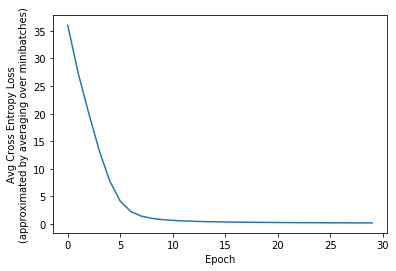

In [21]:
plt.plot(epoch_costs)
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()